In [1]:
import numpy as np
import cvxpy as cp
import scipy.io.wavfile as wav
from numpy.fft import fft
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import signal

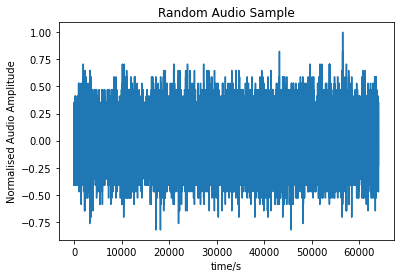

The sampling frequency of the audio is 16000 Hz


In [2]:
# reading the target audio file 
# fs is the sampling frequency
fs, y = wav.read("bandpass\\1.wav")
# normalize the signal amplitude
y = y / y.max()
plt.plot(y)
plt.xlabel("time/s")
plt.ylabel("Normalised Audio Amplitude")
plt.title("Random Audio Sample")
plt.show()
print(f'The sampling frequency of the audio is {fs} Hz')

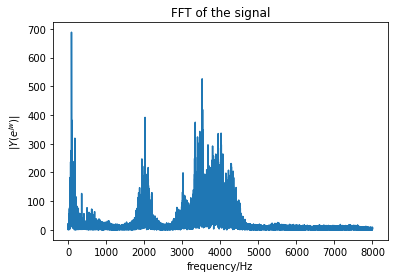

In [3]:
# generate frequency spectrum of the signal
freq = np.linspace(0, fs/2, len(y)//2+1)
y_fft = fft(y)
y_fft = np.abs(y_fft[0:len(y)//2+1])
plt.plot(freq, y_fft)
plt.xlabel("frequency/Hz")
plt.ylabel("$|Y(e^{jw})|$")
plt.title("FFT of the signal")
plt.show()

<Figure size 432x288 with 0 Axes>

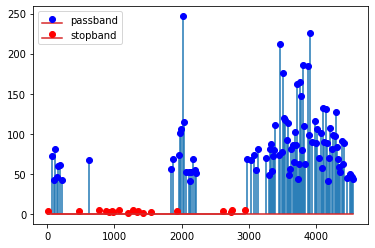

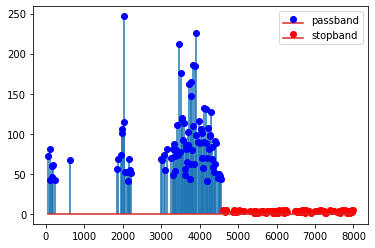

In [49]:
#Todo: implement search for threshold so that
# upp and low threshold have same number of points
num_sample = 500
sample_index = np.linspace(0, len(freq)-1, num_sample).astype(int)
plt.figure()
freq_new = freq[sample_index]
fft_new = y_fft[sample_index]
# threshold for determining the stop and passband
upp_threshold = 40
low_threshold = 5
idx = np.argwhere(fft_new > upp_threshold)
idx2 = np.argwhere(fft_new <= low_threshold)
idx_low = np.setdiff1d(idx2, idx2[idx2>np.max(idx)]).reshape(-1, 1)
idx_high = np.setdiff1d(idx2, idx2[idx2<np.max(idx)]).reshape(-1, 1)
plt.figure()
plt.stem(freq_new[idx], fft_new[idx],markerfmt='bo', label='passband')
plt.stem(freq_new[idx_low], fft_new[idx_low],markerfmt='ro', label='stopband')
plt.legend()
plt.figure()
plt.stem(freq_new[idx], fft_new[idx],markerfmt='bo', label='passband')
plt.stem(freq_new[idx_high], fft_new[idx_high],markerfmt='ro', label='stopband')
plt.legend()

In [55]:
# lower cutoff frequency
pos = np.hstack((freq_new[idx], np.zeros((len(freq_new[idx]), 1))))
neg = np.hstack((freq_new[idx_low], np.zeros((len(freq_new[idx_low]), 1))))
X = np.r_[pos, neg]
Y = np.zeros(len(idx) + len(idx_low))
Y[0:len(idx)] = 1

# SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
# Cutoff Frequency (HZ) for the filter
fc1 = -clf.intercept_[0]/w[0]
# Convert f_c to angular frequency
w_c_1 = (fc/fs)*2*np.pi
print(f"The lower cutoff frequency is {w_c_1:.2f} radians/sample")

The lower cutoff frequency is 0.50 radians/sample


In [57]:
# higher cutoff frequency
pos = np.hstack((freq_new[idx], np.zeros((len(freq_new[idx]), 1))))
neg = np.hstack((freq_new[idx_high], np.zeros((len(freq_new[idx_high]), 1))))
X = np.r_[pos, neg]
Y = np.zeros(len(idx) + len(idx_high))
Y[0:len(idx)] = 1

# SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
# Cutoff Frequency (HZ) for the filter
fc2 = -clf.intercept_[0]/w[0]
# Convert f_c to angular frequency
w_c_2 = (fc2/fs)*2*np.pi
print(f"The higher cutoff frequency is {w_c_2:.2f} radians/sample")

The higher cutoff frequency is 1.80 radians/sample


The following code solves the optimization problem documented in the project report

Code partially adapted from the example given by CVXPY solver 

https://www.cvxpy.org/examples/basic/socp.html

proper citation given in the final report

In [77]:
# Setting random seed of optimization solver
np.random.seed(928065+1042806)

# N is the FIR filter length
# it represents the number of filter coefficients
N = 203

# Quantized Frequencies
# m is the number of constraints
# it specifies the number of quantized frequency
m = 200
w_c_quantized = np.linspace(-np.pi, np.pi, m)
pass_idx = np.argwhere((np.absolute(w_c_quantized) >= w_c_1) & ((np.absolute(w_c_quantized) <= w_c_2)))
stop_idx = np.argwhere((np.absolute(w_c_quantized) < w_c_1) & ((np.absolute(w_c_quantized) > w_c_2)))

# ideal frequency response
H_c = np.zeros(m,dtype=np.complex_)
H_c[pass_idx] = np.exp(-1j*(N-1)*0.5*w_c_quantized[pass_idx])
H_c[stop_idx] = 0

# passband and stopband error 
# for constructing weight function
epsilon_p = 0.01
epsilon_s = 0.03
weight = np.zeros(m)
weight[pass_idx] = 1
weight[stop_idx] = epsilon_p/epsilon_s

# n_i is the row dimension for matrix A_i in ||A_i x+b_i||
# each row is for the real and imaginary component for the frequency response
n_k = 2

# lists to store all the constraints 
A = []
b = []
c = np.zeros(N + 1)
c[0] = 1

# define constraints
for i in range(m):
    w = w_c_quantized[i]
    A_m = np.zeros((2, N+1))
    for j in range(1, N+1):
        A_m[0][j] = np.cos(w*(j-1))
        A_m[1][j] = np.sin(w*(j-1))
    A_m = weight[i]*A_m
    b_m = weight[i]*np.array([-np.real(H_c[i]), np.imag(H_c[i])])
    A.append(A_m)
    b.append(b_m)


# define optimization problem
x = cp.Variable(N+1)
soc_constraints = [cp.SOC(c.T@x, A[i]@x - b[i]) for i in range(m)]
prob = cp.Problem(cp.Minimize(c.T@x), soc_constraints)
prob.solve()

# Print result.
h = x.value[1:]
freq, mag = signal.freqz(h)
scale = 1/max(abs(mag)); 
h = h*scale
print("The optimal filter coefficients are")
print(h)

The optimal filter coefficients are
[ 2.31404267e-03  2.88656797e-03 -2.87505279e-03 -2.45288833e-03
  3.96119818e-04 -5.28132668e-03 -7.86541999e-03  4.61028207e-04
  3.61045366e-03 -1.10363994e-03  2.41994784e-03  8.79899192e-03
  3.42688460e-03 -2.08329525e-03  2.17200136e-03  1.01063081e-03
 -7.54411028e-03 -6.11534758e-03  3.87185226e-04 -2.94835729e-03
 -4.71038862e-03  4.21243002e-03  6.98030344e-03  7.70816994e-04
  2.77993296e-03  7.75734254e-03  3.59487200e-04 -5.83698596e-03
 -8.97166067e-04 -1.34244874e-03 -8.79870777e-03 -5.03659693e-03
  3.38085676e-03  3.05497302e-04 -1.36261296e-03  7.55693449e-03
  8.47871372e-03 -3.31372481e-04  6.19278926e-04  4.69185707e-03
 -3.88754882e-03 -9.72408638e-03 -2.31639690e-03 -1.14625004e-03
 -7.62025641e-03 -1.51306937e-03  8.35670208e-03  3.86044533e-03
  7.12356079e-04  8.89931092e-03  7.82118780e-03 -4.81827498e-03
 -3.55793901e-03  1.52897231e-03 -7.79657813e-03 -1.20690953e-02
 -2.66444105e-04  2.51986175e-03 -4.48312228e-03  3.56

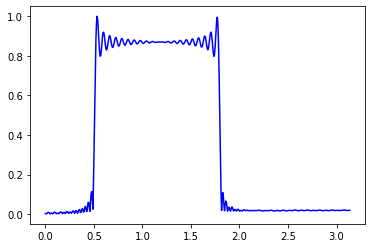

In [78]:
freq, mag = signal.freqz(h)
plt.plot(freq, abs(mag), color='b')